# Exploration

In this section, I attempt to explore the data in depth and also answer some of the questions I developed in the Wrangle section.

1. Across duration and size of packets, where do the attack patterns tend to lie? Types of services? Protocols?
2. Which services are attack patterns usually targeting?
3. Which protocols are attack patterns usually targeting?
4. What is the distribution of attacks to normal traffic? How does this compare with the services and protocols being used? How does this compare with the duration and size of packets?

## Import the data
I need to start first with importing the data.

In [4]:
# For pulling the data
import wrangle as w

# For working with the data
import pandas as pd
import numpy as np

# For visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train,validate,test = w.wrangle_iot2022()

Reading from file...


In [6]:
train.shape

(86181, 84)

## Question 1:
### Across duration and size of packets, where do the attack patterns tend to lie? 


In [8]:
train.columns

Index(['id.orig_p', 'id.resp_p', 'proto', 'service', 'flow_duration',
       'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'flow_CWR_flag_count', 'flow_ECE_flag_count', 'fwd_pkts_payload.min',
       'fwd_pkts_payload.max', 'fwd_pkts_payload.tot', 'fwd_pkts_payload.avg',
       'fwd_pkts_payload.std', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
       'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.std',
       'flow_pkts_payload.min', 'flow_pkts_payload.max',
       'flow_pkts_payload.tot', 'flow_pkts_payload.avg',
     

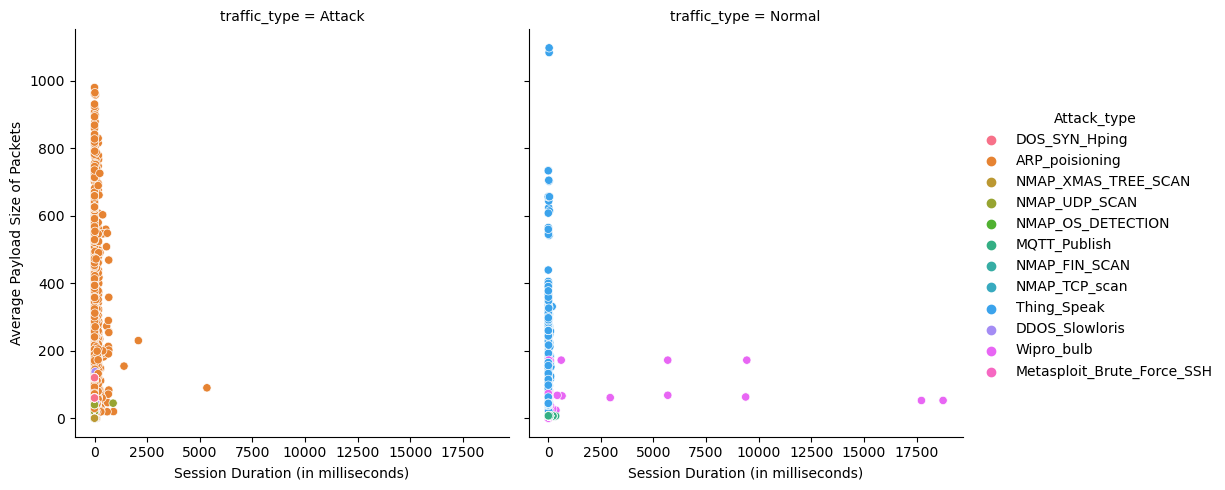

In [9]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='Attack_type',
    kind='scatter',
    col='traffic_type'
).set_axis_labels("Session Duration (in milliseconds)", "Average Payload Size of Packets")

plt.show()

We see here that the attack patterns tend to be very similar to normal traffic, and that there doesn't seem to be much relation between the average size and the duration. However, we can see that the attack durations do tend to be shorter, which makes sense since a threat actor may want to keep his or her patterns less noticeable.

### Where do the types of services tend to lie?

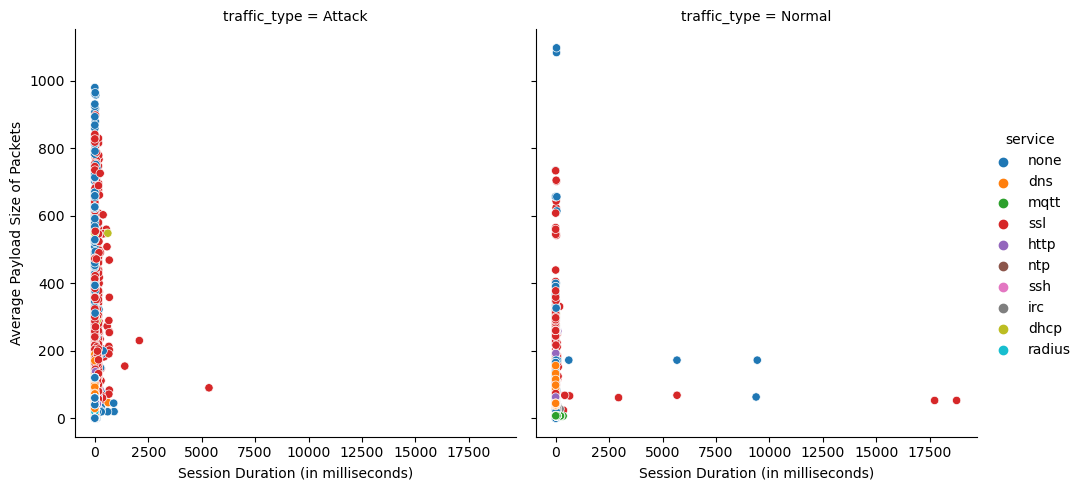

In [12]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='service',
    kind='scatter',
    col='traffic_type'
).set_axis_labels("Session Duration (in milliseconds)", "Average Payload Size of Packets")

plt.show()

Unfortunately, this doesn't really show much besides showing that the attack patterns may favor the 'none' or no particular service and the 'ssl' services, and that attack patterns may look very similar to normal traffic.

### Where do the protocols tend to lie?

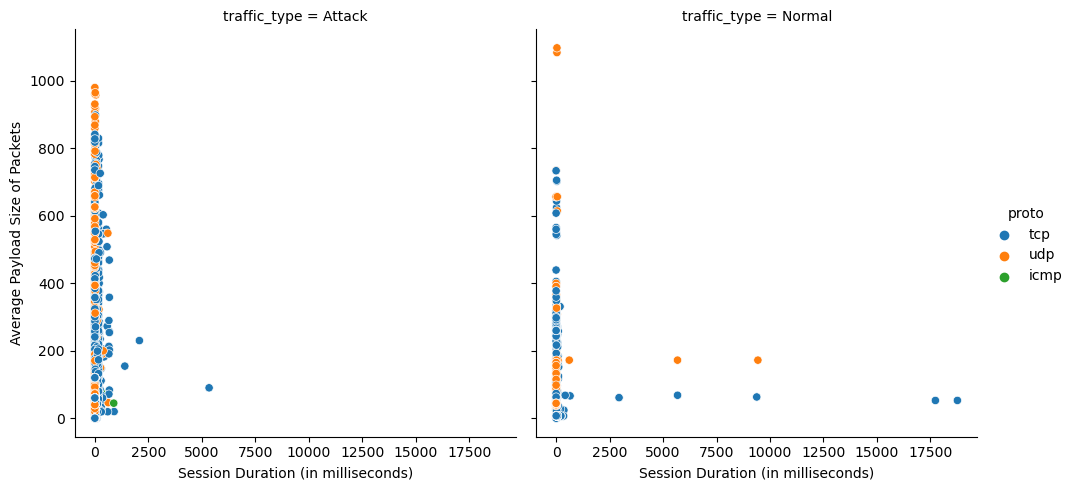

In [15]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='proto',
    kind='scatter',
    col='traffic_type'
).set_axis_labels("Session Duration (in milliseconds)", "Average Payload Size of Packets")

plt.show()

Here we see a similar thing, where the attack traffic follows a similar appearance to normal traffic.

## Question 2:
### Which services are attack patterns usually targeting?

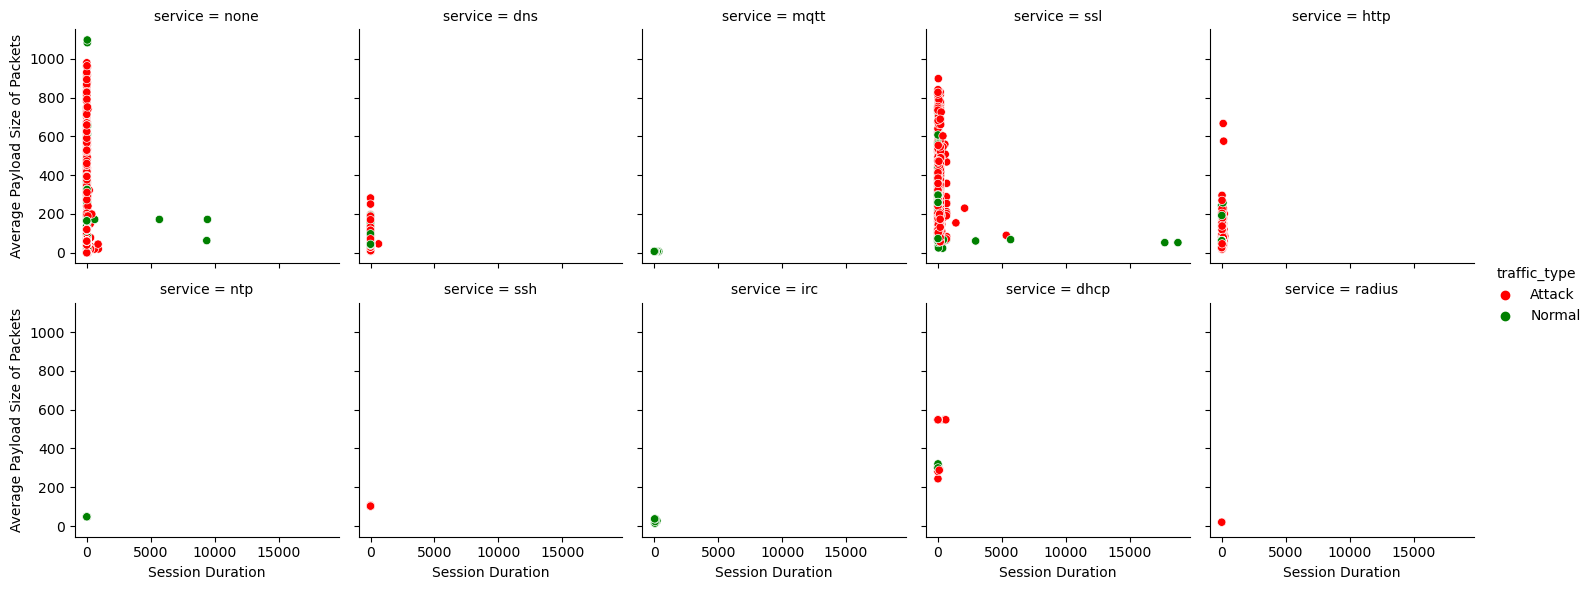

In [18]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"},
    kind='scatter',
    col='service',
    col_wrap=5,
    height=3,
    aspect=1  # Adjust aspect ratio to spread plots wider
).set_axis_labels("Session Duration", "Average Payload Size of Packets")

plt.show()

Here we can see that there are some services that don't appear to be targeted, such as irc, ntp, and mqtt.

I'd like to verify that, though.

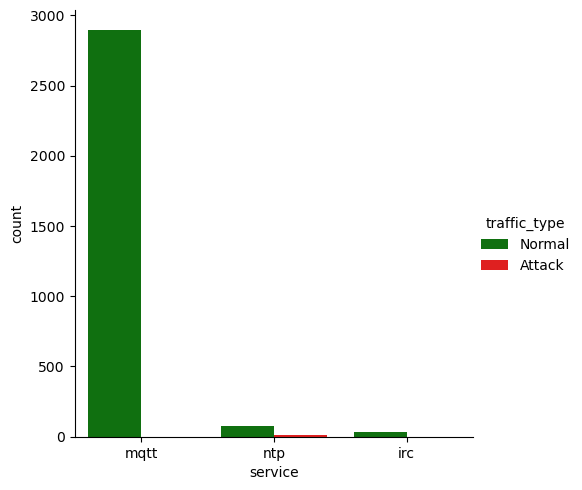

service  traffic_type
mqtt     Normal          2893
ntp      Normal            74
irc      Normal            31
ntp      Attack            10
Name: count, dtype: int64

In [20]:
sns.catplot(
    kind='count',
    data=train[train['service'].isin(['irc', 'mqtt', 'ntp'])],
    x='service',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"}
)

plt.show()

# Show the raw data
train[train['service'].isin(['irc', 'mqtt', 'ntp'])][['service','traffic_type']].value_counts()

Here we can see that yes, there are some services that are *not* targeted, but we can *also* see that sometimes the attacks are so few that they rarely show up.

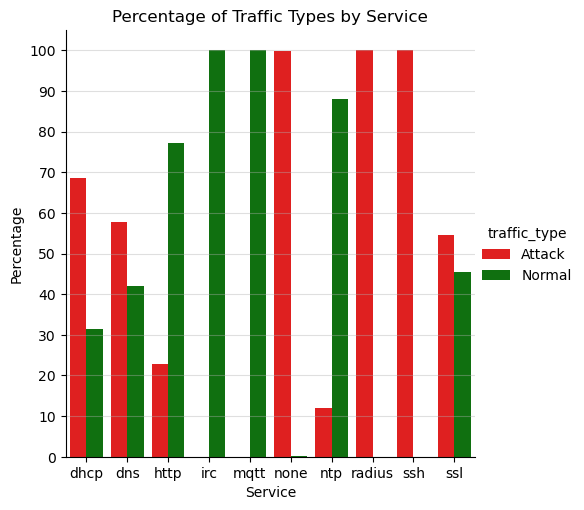

In [22]:
# Step 1: Calculate counts
grouped = train.groupby(['service', 'traffic_type']).size().reset_index(name='counts')

# Step 2: Calculate total counts for each service to use for percentage calculation
total_counts = grouped.groupby('service')['counts'].transform('sum')

# Convert counts to percentages
grouped['percentage'] = (grouped['counts'] / total_counts) * 100

# Step 3: Create the plot
sns.catplot(
    kind='bar',  # Use bar type to show percentages
    data=grouped,
    x='service',
    y='percentage',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"}
)

# Adding more descriptive labels
plt.xlabel('Service')
plt.ylabel('Percentage')
plt.yticks(list(range(0,110,10)))
plt.title('Percentage of Traffic Types by Service')
plt.grid(alpha=0.4,axis='y')

plt.show()

Overall, of the services targeted, they seem to be largely the 'none' type, RADIUS, SSH, and DHCP. Being that RADIUS and SSH are especially used in authentication, this makes sense as a threat actor would prefer to have continued access to the network.

## Question 3:
### Which protocols are attack patterns usually targeting?

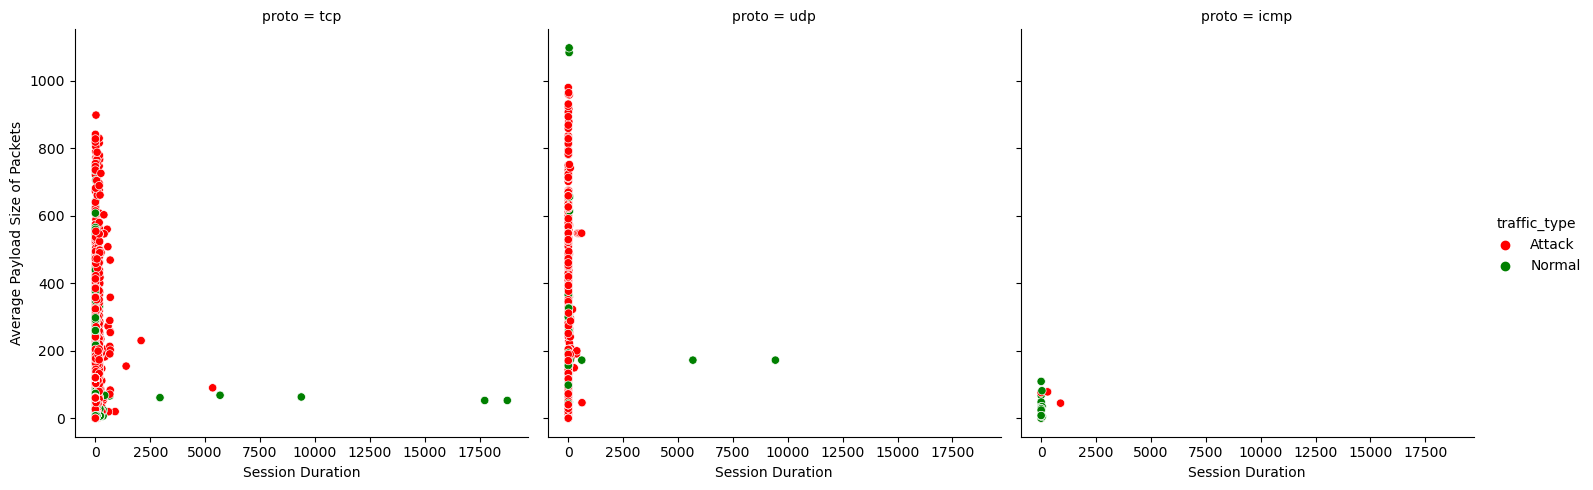

In [25]:
sns.relplot(
    data=train,
    x='flow_duration',
    y='flow_pkts_payload.avg',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"},
    kind='scatter',
    col='proto'
).set_axis_labels("Session Duration", "Average Payload Size of Packets")

plt.show()

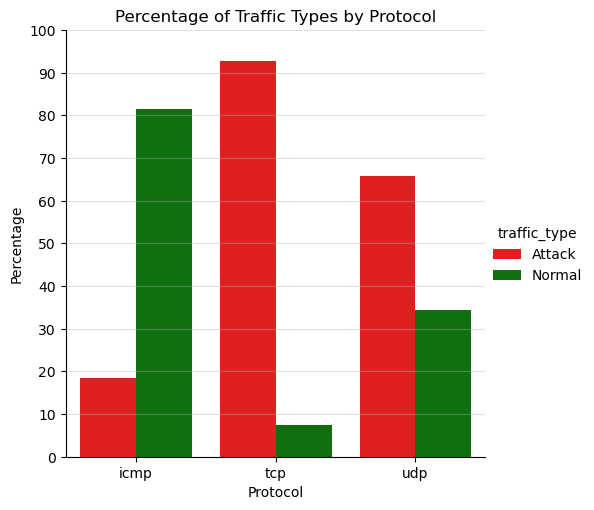

In [26]:
# Step 1: Calculate counts
grouped = train.groupby(['proto', 'traffic_type']).size().reset_index(name='counts')

# Step 2: Calculate total counts for each protocol to use for percentage calculation
total_counts = grouped.groupby('proto')['counts'].transform('sum')

# Convert counts to percentages
grouped['percentage'] = (grouped['counts'] / total_counts) * 100

# Step 3: Create the plot
sns.catplot(
    kind='bar',  # Use bar type to show percentages
    data=grouped,
    x='proto',
    y='percentage',
    hue='traffic_type',
    palette={"Attack": "red", "Normal": "green"}
)

# Adding more descriptive labels
plt.xlabel('Protocol')
plt.ylabel('Percentage')
plt.yticks(list(range(0,110,10)))
plt.title('Percentage of Traffic Types by Protocol')
plt.grid(alpha=0.4,axis='y')

plt.show()

The protocols indicate that of the attack patterns, the ICMP protocol is least targeted, while TCP is overwhelmingly targeted, and UDP in the middle with its attacks being almost twice the amount of its normal traffic patterns

## Question 4:
### What is the distribution of attacks to normal traffic? 


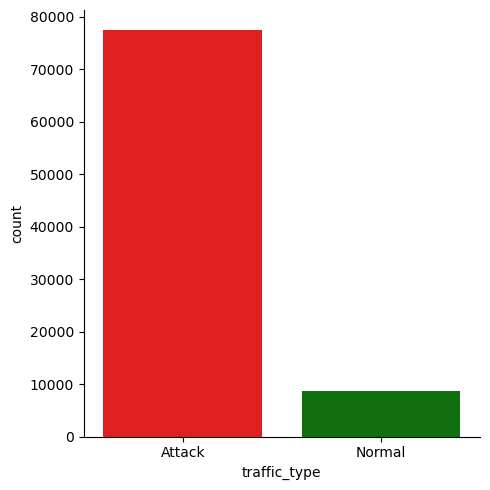

In [29]:
sns.catplot(
    data=train,
    kind='count',
    x='traffic_type',
    palette={
        'Attack':'red',
        'Normal':'green'
    }
)

plt.show()

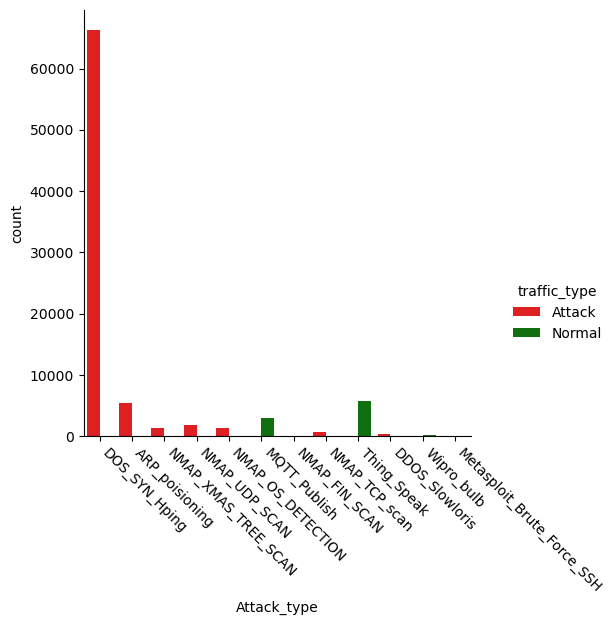

In [30]:
sns.catplot(
    data=train,
    kind='count',
    x='Attack_type',
    hue='traffic_type',
    palette={
        'Attack':'red',
        'Normal':'green'
    }
)
plt.xticks(rotation=-45,ha="left")
plt.show()

The distribution of attacks to normal traffic is overwhelmingly in favor of the attacks. This is likely due to the dataset being built for predicting attack patterns.

### How does this compare with the services and protocols being used? 

In [33]:
train.groupby(['traffic_type','service']).size()

traffic_type  service
Attack        dhcp          24
              dns         3943
              http         556
              none       71852
              ntp           10
              radius         2
              ssh           18
              ssl         1022
Normal        dhcp          11
              dns         2870
              http        1876
              irc           31
              mqtt        2893
              none         144
              ntp           74
              ssl          855
dtype: int64

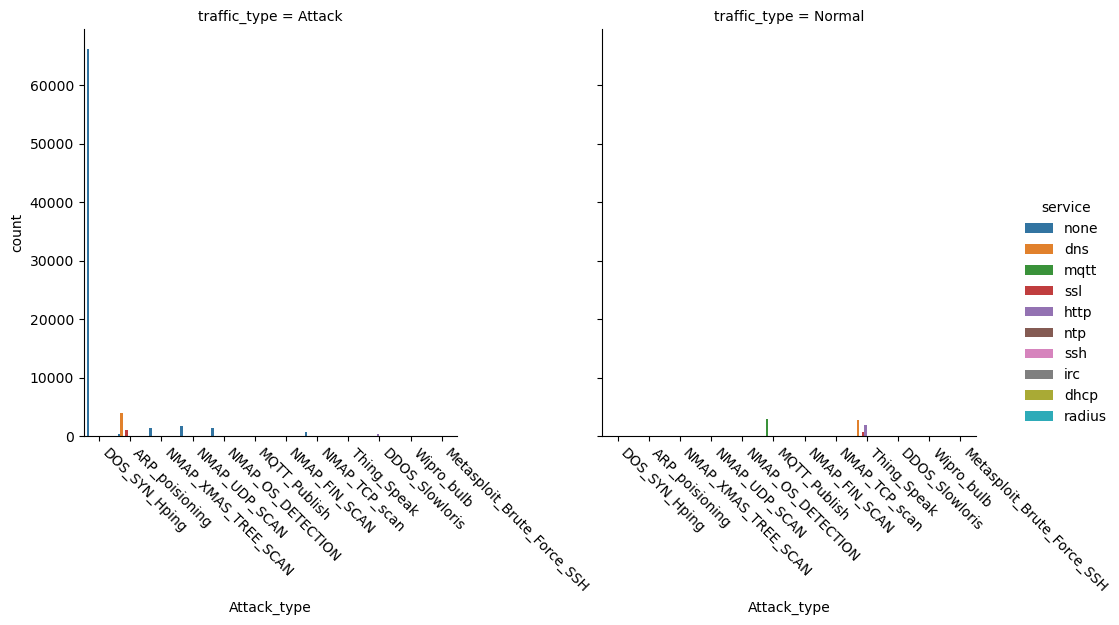

In [69]:
sns.catplot(
    data=train,
    kind='count',
    x='Attack_type',
    hue='service',
    col='traffic_type',
    # palette={'Attack':'red','Normal':'green'}
).set_xticklabels(rotation=-45,ha="left")

# plt.xticks(rotation=-45,ha="left")

plt.show()

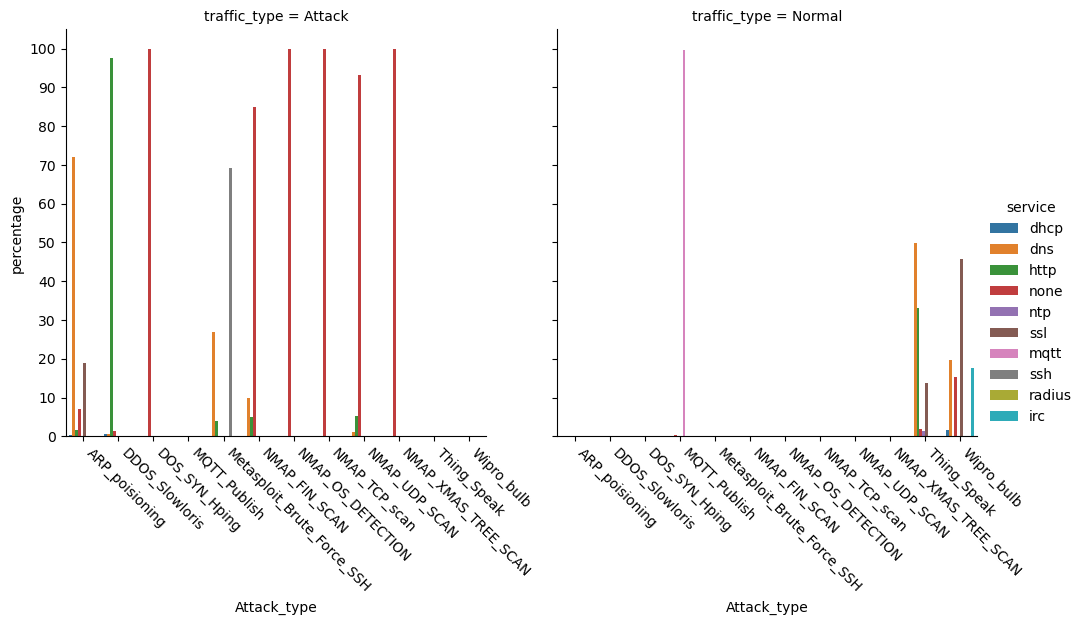

In [83]:
# Step 1: Calculate counts
counts = train.groupby(['Attack_type', 'service', 'traffic_type']).size().reset_index(name='counts')

# Step 2: Compute percentages
total_counts = counts.groupby(['Attack_type', 'traffic_type'])['counts'].transform('sum')
counts['percentage'] = (counts['counts'] / total_counts) * 100

# Step 3: Create the plot using calculated percentages
sns.catplot(
    data=counts,
    kind='bar',  # Changed to bar to show percentages more clearly
    x='Attack_type',
    y='percentage',
    hue='service',
    col='traffic_type',
    # Uncomment and set the palette if needed
    # palette={'Attack':'red', 'Normal':'green'}
).set_xticklabels(rotation=-45, ha="left")
plt.yticks(list(range(0,110,10)))
plt.show()

### How does this compare with the duration and size of packets?

## Turn them into functions!
I need to convert all these into functions that I can use and that will easily display the information I need/want.

### Q1

In [107]:
def q1(df):
    """
    <summary>
    
    Parameters:
    -----------
    
    Returns:
    --------
    
    """
    # print question part 1
    print("Across duration and size of packets, where do the attack patterns tend to lie?")
    sns.relplot(
        data=df,
        x='flow_duration',
        y='flow_pkts_payload.avg',
        hue='Attack_type',
        kind='scatter',
        col='traffic_type'
    ).set_axis_labels("Session Duration (in milliseconds)", "Average Payload Size of Packets")
    plt.show()
    print("We see here that the attack patterns tend to be very similar to normal traffic, and that there doesn't seem to be much relation between the average size and the duration. However, we can see that the attack durations do tend to be shorter, which makes sense since a threat actor may want to keep his or her patterns less noticeable.\n")
    
    # print question part 2
    print("Where do the types of services tend to lie?")
    sns.relplot(
        data=df,
        x='flow_duration',
        y='flow_pkts_payload.avg',
        hue='service',
        kind='scatter',
        col='traffic_type'
    ).set_axis_labels("Session Duration (in milliseconds)", "Average Payload Size of Packets")
    plt.show()
    
    # print question part 3
    print("Where do the protocols tend to lie?")
    sns.relplot(
        data=df,
        x='flow_duration',
        y='flow_pkts_payload.avg',
        hue='proto',
        kind='scatter',
        col='traffic_type'
    ).set_axis_labels("Session Duration (in milliseconds)", "Average Payload Size of Packets")
    plt.show()
    print("We see that as above, threat actors attempt to keep much of their network traffic as similar as possible to regular network traffic in order to go unnoticed.")
    
    return None

Across duration and size of packets, where do the attack patterns tend to lie?


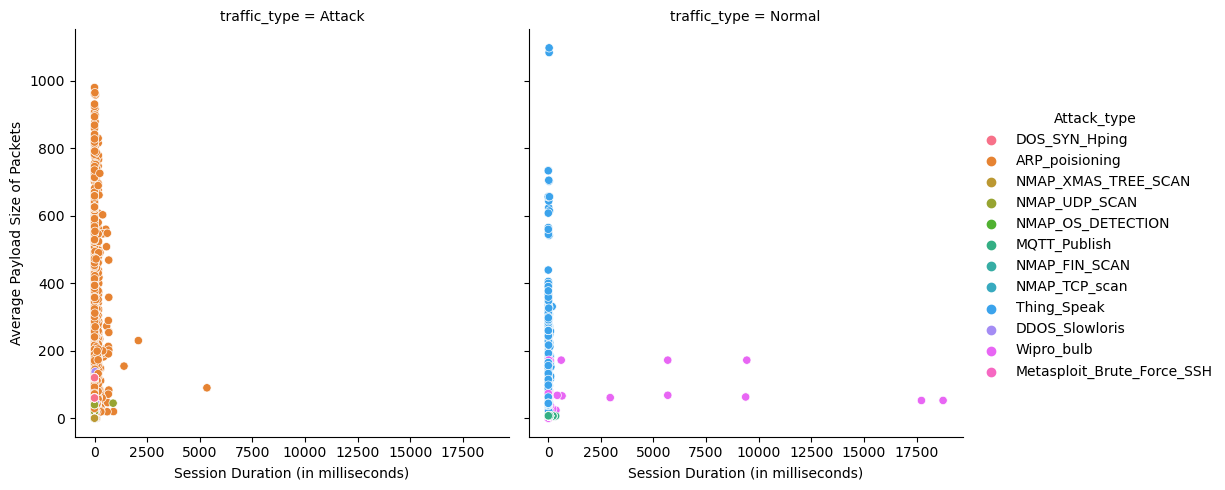

We see here that the attack patterns tend to be very similar to normal traffic, and that there doesn't seem to be much relation between the average size and the duration. However, we can see that the attack durations do tend to be shorter, which makes sense since a threat actor may want to keep his or her patterns less noticeable.

Where do the types of services tend to lie?


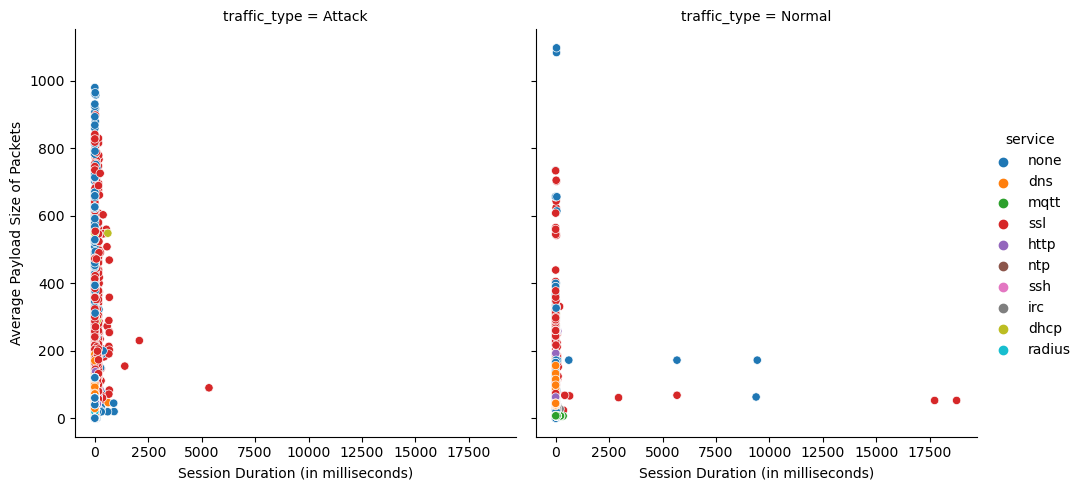

Where do the protocols tend to lie?


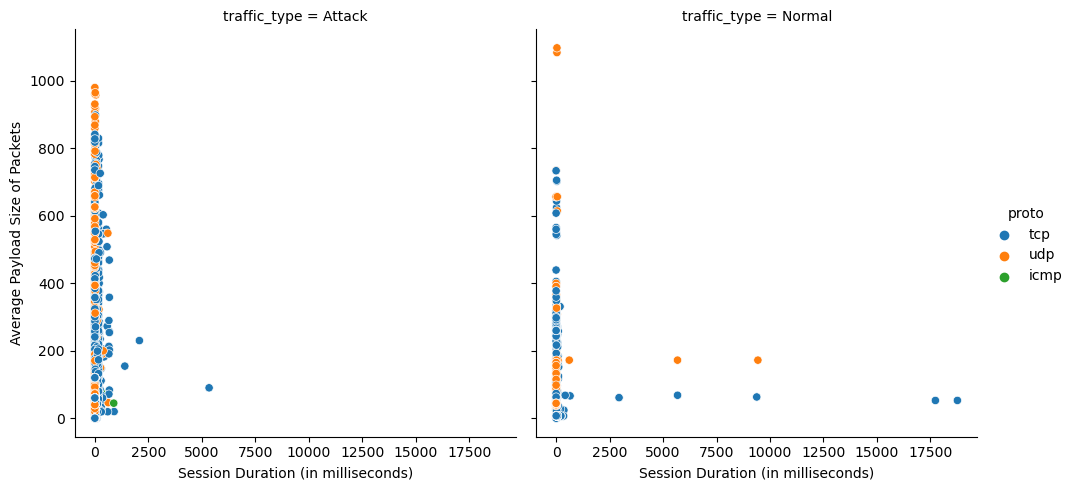

We see that as above, threat actors attempt to keep much of their network traffic as similar as possible to regular network traffic in order to go unnoticed.


In [127]:
q1(train)

### Q2

In [133]:
def q2(df):
    """
    <summary>
    
    Parameters:
    -----------
    
    Returns:
    --------
    
    """
    print("Which services are attack patterns usually targeting?")
    sns.relplot(
        data=df,
        x='flow_duration',
        y='flow_pkts_payload.avg',
        hue='traffic_type',
        palette={"Attack": "red", "Normal": "green"},
        kind='scatter',
        col='service',
        col_wrap=5,
        height=3,
        aspect=1  # Adjust aspect ratio to spread plots wider
    ).set_axis_labels("Session Duration", "Average Payload Size of Packets")
    plt.show()
    
    # Step 1: Calculate counts
    grouped = train.groupby(['service', 'traffic_type']).size().reset_index(name='counts')

    # Step 2: Calculate total counts for each service to use for percentage calculation
    total_counts = grouped.groupby('service')['counts'].transform('sum')

    # Convert counts to percentages
    grouped['percentage'] = (grouped['counts'] / total_counts) * 100

    # Step 3: Create the plot
    sns.catplot(
        kind='bar',  # Use bar type to show percentages
        data=grouped,
        x='service',
        y='percentage',
        hue='traffic_type',
        palette={"Attack": "red", "Normal": "green"}
    )

    # Adding more descriptive labels
    plt.xlabel('Service')
    plt.ylabel('Percentage')
    plt.yticks(list(range(0,110,10)))
    plt.title('Percentage of Traffic Types by Service')
    plt.grid(alpha=0.4,axis='y')

    plt.show()
    
    print("Overall, of the services targeted, they seem to be largely the 'none' type, RADIUS, SSH, and DHCP. Being that RADIUS and SSH are especially used in authentication, this makes sense as a threat actor would prefer to have continued access to the network.")
    
    
    return None

Which services are attack patterns usually targeting?


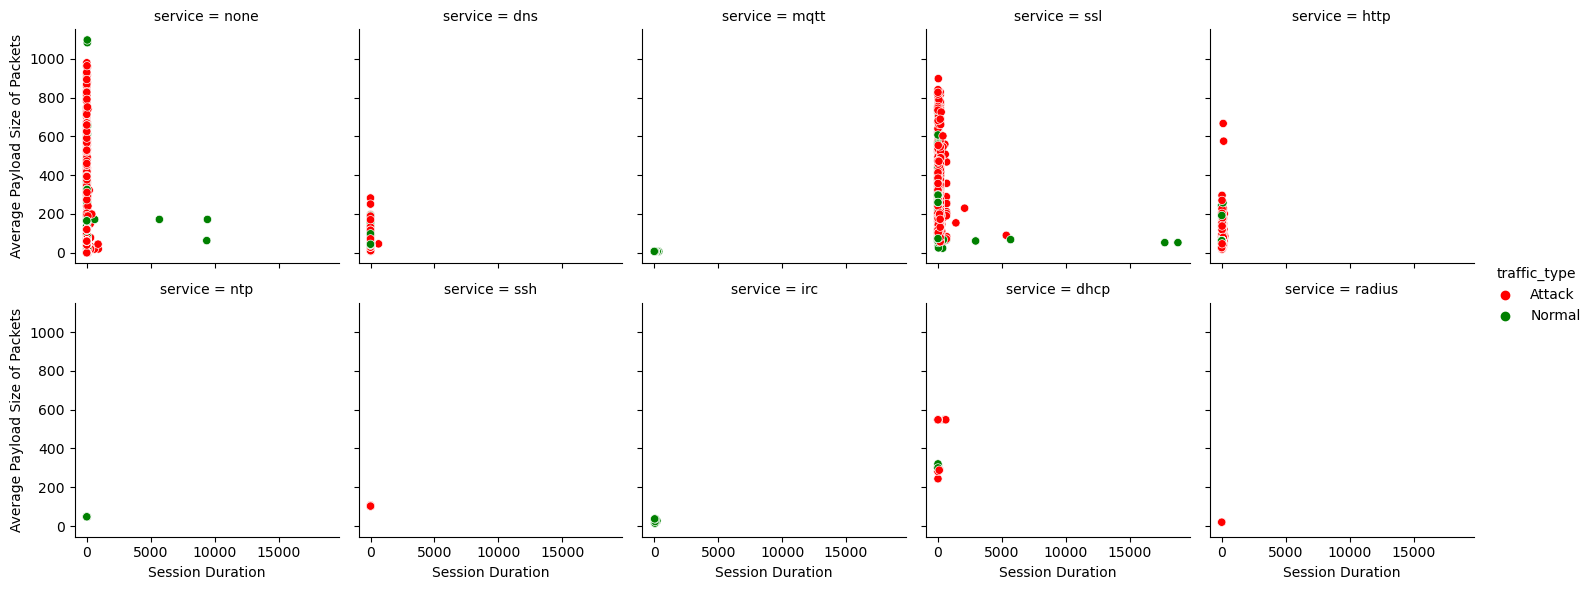

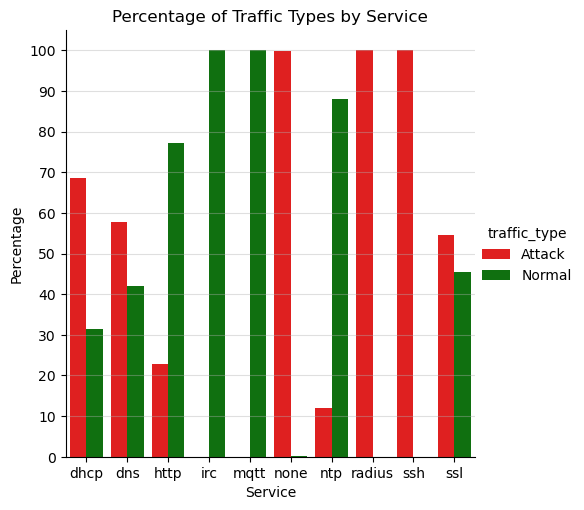

Overall, of the services targeted, they seem to be largely the 'none' type, RADIUS, SSH, and DHCP. Being that RADIUS and SSH are especially used in authentication, this makes sense as a threat actor would prefer to have continued access to the network.


In [135]:
q2(train)

### Q3

In [141]:
def q3(df):
    """
    <summary>
    
    Parameters:
    -----------
    
    Returns:
    --------
    
    """
    print("Which protocols are attack patterns usually targeting?")
    
    sns.relplot(
        data=df,
        x='flow_duration',
        y='flow_pkts_payload.avg',
        hue='traffic_type',
        palette={"Attack": "red", "Normal": "green"},
        kind='scatter',
        col='proto'
    ).set_axis_labels("Session Duration", "Average Payload Size of Packets")
    plt.show()
    
    # Step 1: Calculate counts
    grouped = train.groupby(['proto', 'traffic_type']).size().reset_index(name='counts')

    # Step 2: Calculate total counts for each protocol to use for percentage calculation
    total_counts = grouped.groupby('proto')['counts'].transform('sum')

    # Convert counts to percentages
    grouped['percentage'] = (grouped['counts'] / total_counts) * 100

    # Step 3: Create the plot
    sns.catplot(
        kind='bar',  # Use bar type to show percentages
        data=grouped,
        x='proto',
        y='percentage',
        hue='traffic_type',
        palette={"Attack": "red", "Normal": "green"}
    )

    # Adding more descriptive labels
    plt.xlabel('Protocol')
    plt.ylabel('Percentage')
    plt.yticks(list(range(0,110,10)))
    plt.title('Percentage of Traffic Types by Protocol')
    plt.grid(alpha=0.4,axis='y')

    plt.show()
    print("The protocols indicate that of the attack patterns, the ICMP protocol is least targeted, while TCP is overwhelmingly targeted, and UDP in the middle with its attacks being almost twice the amount of its normal traffic patterns")
    
    
    return None

Which protocols are attack patterns usually targeting?


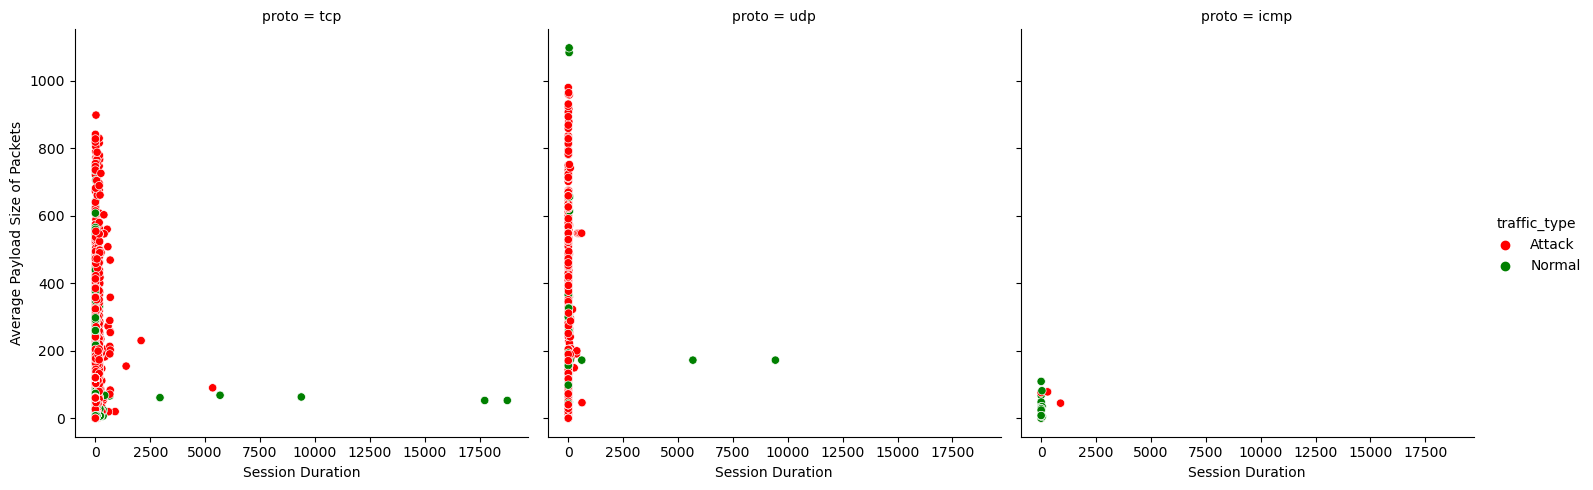

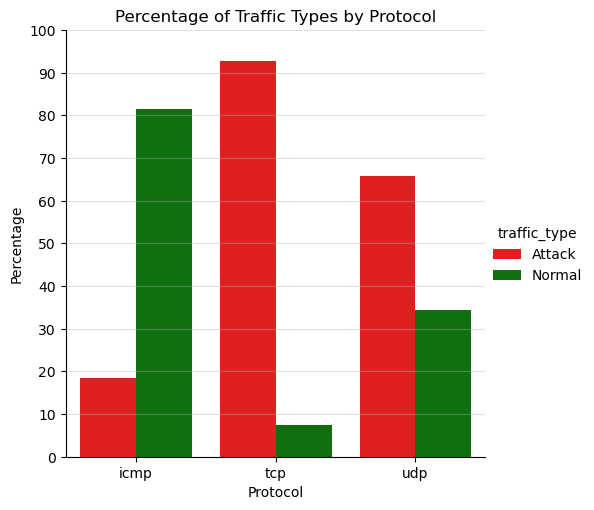

The protocols indicate that of the attack patterns, the ICMP protocol is least targeted, while TCP is overwhelmingly targeted, and UDP in the middle with its attacks being almost twice the amount of its normal traffic patterns


In [143]:
q3(train)

### Q4

In [148]:
def q4(df):
    """
    <summary>
    
    Parameters:
    -----------
    
    Returns:
    --------
    
    """
    print("What is the distribution of attacks to normal traffic?")
    sns.catplot(
        data=df,
        kind='count',
        x='traffic_type',
        palette={
            'Attack':'red',
            'Normal':'green'
        }
    )
    plt.show()
    
    sns.catplot(
        data=df,
        kind='count',
        x='Attack_type',
        hue='traffic_type',
        palette={
            'Attack':'red',
            'Normal':'green'
        }
    )
    plt.xticks(rotation=-45,ha="left")
    plt.show()
    
    print("How does this compare with the services and protocols being used?")
    # Step 1: Calculate counts
    counts = df.groupby(['Attack_type', 'service', 'traffic_type']).size().reset_index(name='counts')

    # Step 2: Compute percentages
    total_counts = counts.groupby(['Attack_type', 'traffic_type'])['counts'].transform('sum')
    counts['percentage'] = (counts['counts'] / total_counts) * 100

    # Step 3: Create the plot using calculated percentages
    sns.catplot(
        data=counts,
        kind='bar',  # Changed to bar to show percentages more clearly
        x='Attack_type',
        y='percentage',
        hue='service',
        col='traffic_type',
        # Uncomment and set the palette if needed
        # palette={'Attack':'red', 'Normal':'green'}
    ).set_xticklabels(rotation=-45, ha="left")
    plt.yticks(list(range(0,110,10)))
    plt.show()
    print("We can see that the primarily targeted service is most of all generic and not at particular services, and the most used is the DOS_SYN_Hping.")
    
    
    
    return None

What is the distribution of attacks to normal traffic?


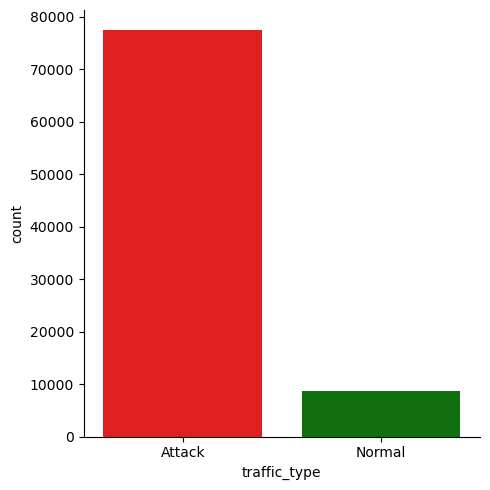

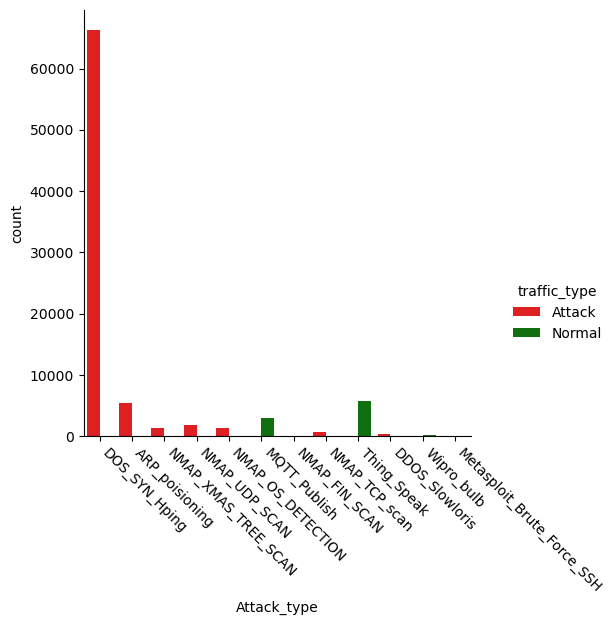

How does this compare with the services and protocols being used?


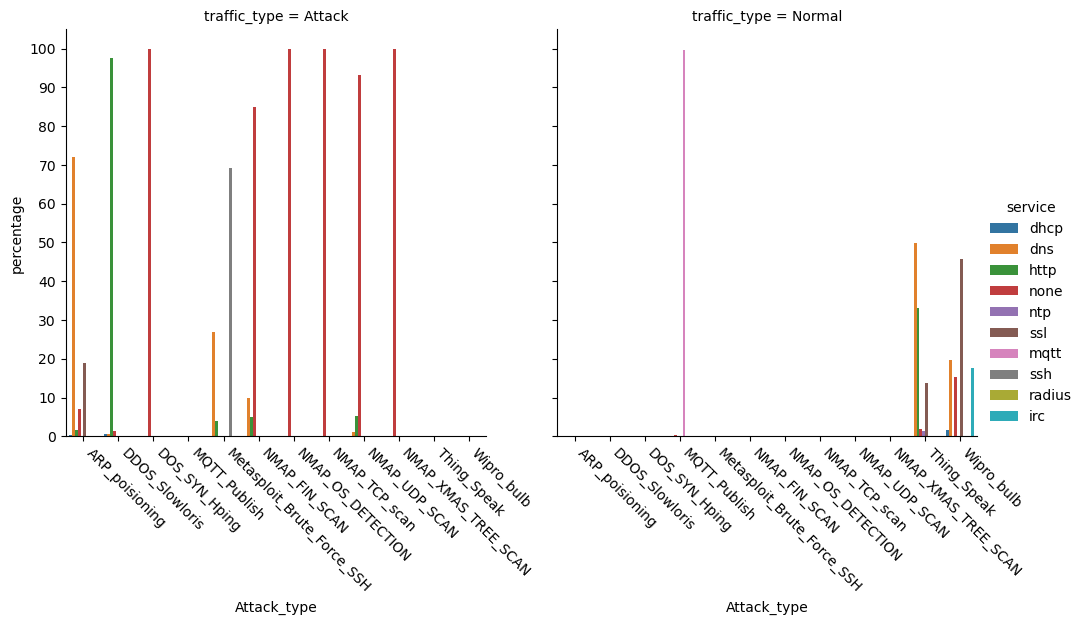

We can see that the primarily targeted service is most of all generic and not at particular services, and the most used is the DOS_SYN_Hping.


In [150]:
q4(train)